# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import os
from dotenv import load_dotenv
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import boto3
from catboost import CatBoostClassifier, Pool
import scipy
import sklearn.preprocessing
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares 

In [2]:
load_dotenv()

aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID_STUDENT')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY_STUDENT')
aws_endpoint_url = 'https://storage.yandexcloud.net/'
aws_bucket_name = os.getenv('STUDENT_S3_BUCKET')

session = boto3.session.Session()
s3_client = session.client(
    service_name='s3',
    endpoint_url=aws_endpoint_url,
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key
)

def upload_to_s3(filename, bucket):
    try:
        s3_client.upload_file(filename, bucket, f'recsys/data/{filename}')
    except Exception as error:
        print(error)

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

In [4]:
pd.options.mode.chained_assignment = None

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [4]:
catalog_names = pd.read_parquet("catalog_names.parquet")

In [103]:
tracks = pd.read_parquet("tracks.parquet")
interactions = pd.read_parquet("interactions.parquet")

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [105]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


In [106]:
tracks.sample(5, random_state=42)

,track_id,albums,artists,genres
987231,95229664,[19388714],[222689],[11]
79954,700056,[37164],[118708],"[7, 112, 61]"
567130,39019190,[1806703],[2720477],[12]
500891,34625231,[4271134],[4732313],[68]
55399,518436,"[55672, 55673, 4497446, 4497447, 4497448, 4497...","[29903, 322, 316, 321, 319, 320]",[68]


In [107]:
# Проверяем дубликаты
tracks['track_id'].duplicated().sum()

0

In [108]:
# Самое большое значение идентификатора
tracks['track_id'].max()

101521819

In [109]:
# Проверяем пропуски
tracks.isna().sum()

track_id    0
albums      0
artists     0
genres      0
dtype: int64

In [110]:
# Треки с пропущенным жанром
len(tracks[tracks['genres'].str.len() == 0])

3687

In [111]:
# Треки с пропущенным артистом
len(tracks[tracks['artists'].str.len() == 0])

15369

In [112]:
# Треки с пропущенным альбомом
len(tracks[tracks['albums'].str.len() == 0])

18

In [113]:
# Делаем track_id индексным столбцом
tracks.set_index('track_id', inplace=True)

In [114]:
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [115]:
# Типы записей
catalog_names['type'].value_counts()

type
track     1000000
album      658724
artist     153581
genre         166
Name: count, dtype: int64

In [116]:
# Так как в колонке "type" всего четыре уникальных значения, мы можем поменять тип данных на category
catalog_names['type'] = catalog_names['type'].astype('category')

In [117]:
# Использование памяти существенно сократилось
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype   
---  ------  -----   
 0   id      int64   
 1   type    category
 2   name    object  
dtypes: category(1), int64(1), object(1)
memory usage: 29.4+ MB


In [118]:
catalog_names.sample(5, random_state=42)

,id,type,name
1514369,51822590,track,Музыка в фильмах Тарантино
437151,8810199,album,Shadow
1800488,95436616,track,Ключ
635810,19044912,album,Gnomi Di Natale
1436508,43503873,track,Пароль


In [119]:
catalog_names[catalog_names['id'] == 95229664]

,id,type,name
1799702,95229664,track,Have Yourself A Merry Little Christmas


In [120]:
catalog_names[catalog_names['id'] == 19388714]

,id,type,name
639952,19388714,album,Have Yourself A Merry Little Christmas


In [121]:
catalog_names[catalog_names['id'] == 11]

,id,type,name
812316,11,genre,pop


In [122]:
# Проверяем пропуски
catalog_names.isna().sum()

id      0
type    0
name    0
dtype: int64

In [123]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


In [124]:
interactions.sample(5, random_state=42)

,user_id,track_id,track_seq,started_at
130,844258,3581309,131,2022-06-05
433,1091434,14937363,434,2022-06-29
526,73981,48591660,527,2022-09-26
9,78605,732405,10,2022-09-14
1202,1273064,40339506,1203,2022-08-24


In [125]:
interactions[interactions['user_id'] == 844258] \
    .merge(tracks, on='track_id')

,user_id,track_id,track_seq,started_at,albums,artists,genres
0,844258,9610,1,2022-05-19,"[967, 1208, 5950, 5981, 9341, 10703, 23866, 67...",[451],[11]
1,844258,12080,2,2022-05-19,"[1158, 1826, 2800, 4234, 7045, 621326, 6929419...","[3465, 5639]",[74]
2,844258,34608,3,2022-05-19,"[2874, 6352, 7270, 8476, 87789, 87791, 2488490...",[9278],"[41, 47]"
3,844258,37475,4,2022-05-19,"[3109, 3487, 4739, 9825, 10748, 9210251, 92102...",[5976],[13]
4,844258,47680,5,2022-05-19,"[3919, 4202, 4489, 4864, 5796, 6218, 10748, 37...",[5976],[13]
...,...,...,...,...,...,...,...
1200,844258,98123699,1201,2022-11-06,[20327103],[3749834],[11]
1201,844258,99779643,1202,2022-11-06,[20875901],"[6005099, 5458792]",[70]
1202,844258,99911813,1203,2022-11-06,[20910238],[8553938],"[6, 70]"
1203,844258,100215030,1204,2022-11-06,[21007097],[3146056],"[6, 70]"


In [126]:
interactions.describe()

,user_id,track_id,track_seq,started_at
count,2.226299e+08,2.226299e+08,2.226299e+08,222629898
mean,6.875767e+05,3.653622e+07,4.621403e+02,2022-08-29 16:39:44.541336320
min,0.000000e+00,2.600000e+01,1.000000e+00,2022-01-01 00:00:00
25%,3.433710e+05,1.480849e+07,5.600000e+01,2022-07-02 00:00:00
50%,6.879730e+05,3.552474e+07,1.810000e+02,2022-09-15 00:00:00
75%,1.031127e+06,5.651137e+07,5.060000e+02,2022-11-09 00:00:00
max,1.374582e+06,1.015218e+08,1.663700e+04,2022-12-31 00:00:00
std,3.969033e+05,2.661782e+07,8.257312e+02,NaN


In [127]:
# Проверяем пропуски
interactions.isna().sum()

user_id       0
track_id      0
track_seq     0
started_at    0
dtype: int64

In [128]:
# Количество взаимодействий
len(interactions)

222629898

In [129]:
# Количество уникальных пользователей
interactions['user_id'].nunique()

1373221

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

В таблице `tracks` есть элементы с пропущенными значениями жанров/альбомов/артистов, однако их удалять не обязательно. В остальном в даных нет существенных пропусков и дубликатов данных.

В таблице с `catalog_names` для колонки "type" был заменен тип данных на category. Остальные типы данных, включая идентификаторы, соответствуют оперируемым значениям. 

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

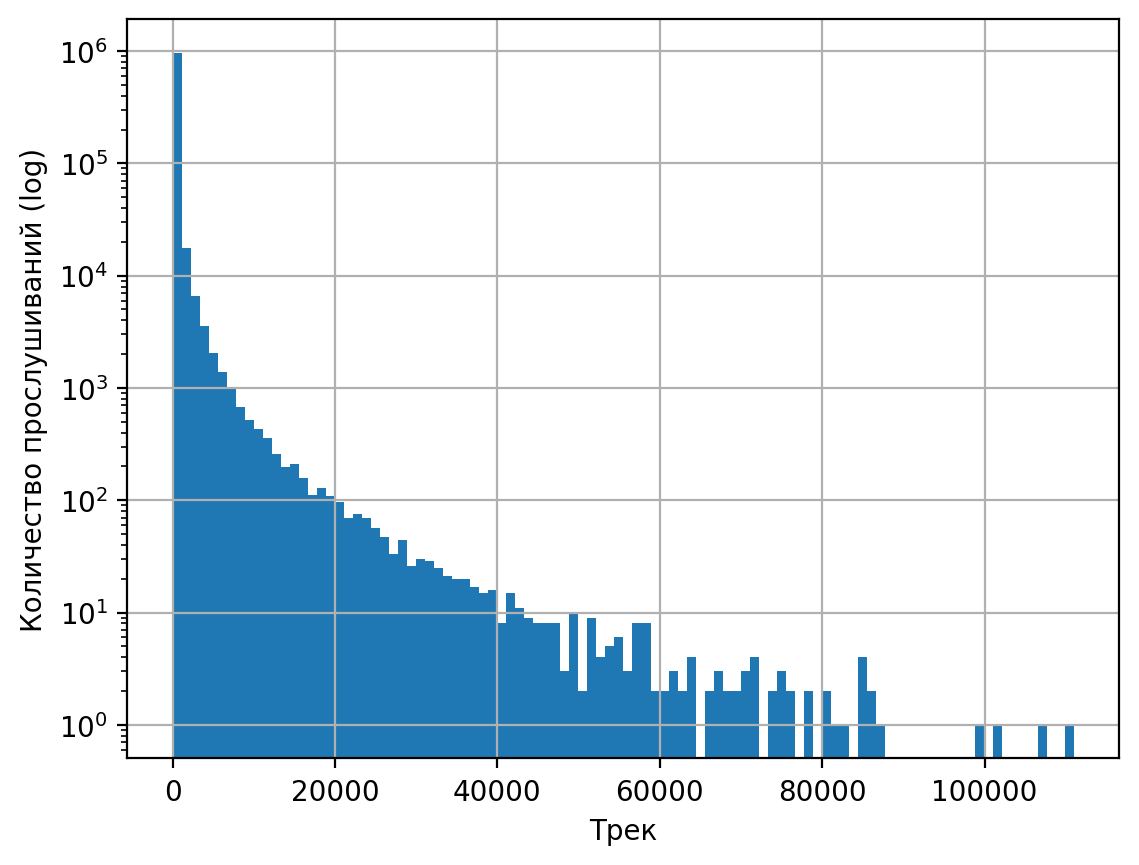

In [134]:
# Распределение всех прослушанных треков
ax = interactions['track_id'].value_counts().hist(bins=100, log=True)

ax.set_xlabel("Трек")
ax.set_ylabel("Количество прослушиваний (log)")
plt.show()

Наиболее популярные треки

In [135]:
top_items = pd.DataFrame(interactions['track_id'].value_counts()) \
    .join(catalog_names.set_index('id')) \
    .sort_values('count', ascending=False)

In [136]:
top_items[top_items['type'] == 'track'].head(10)

,count,type,name
track_id,,,
53404,111062,track,Smells Like Teen Spirit
33311009,106921,track,Believer
178529,101924,track,Numb
35505245,99490,track,I Got Love
65851540,86670,track,Юность
24692821,86246,track,Way Down We Go
32947997,85886,track,Shape of You
51241318,85244,track,In The End
795836,85042,track,Shape Of My Heart


Наиболее популярные жанры

In [137]:
genres_counts = top_items.join(tracks).explode('genres')['genres'].value_counts()

In [138]:
top_genres = pd.DataFrame(genres_counts).join(catalog_names[catalog_names['type'] == 'genre'].set_index('id')['name'])
top_genres.head(10)

,count,name
genres,,
11,171768,pop
75,129815,rap
102,124214,allrock
68,115864,electronics
47,74998,metal
3,66175,rusrap
44,61144,foreignrap
14,59098,rock
16,52167,dance


Треки, которые никто не прослушал

In [139]:
tracks[~tracks.index.isin(interactions['track_id'])]

,albums,artists,genres
track_id,,,


Все треки были прослушаны хотя бы одним пользователем

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [141]:
# Оставляем только пользователей, которые слушали больше одного трека
atleast_two_interactions = interactions[['user_id']].groupby('user_id').size().to_frame('size')
atleast_two_interactions = atleast_two_interactions[atleast_two_interactions['size'] >= 2]

In [142]:
interactions = interactions[interactions['user_id'].isin(atleast_two_interactions.index)]

In [143]:
# В данных присутствуют треки без жанров/альбомов/артистов. Удаляем их из tracks и events
no_genres_track_ids = set(tracks[tracks['genres'].str.len() == 0].index)
no_albums_track_ids = set(tracks[tracks['albums'].str.len() == 0].index)
no_artists_track_ids = set(tracks[tracks['artists'].str.len() == 0].index)

In [144]:
print('Количество треков без жанров:', len(no_genres_track_ids))
print('Количество треков без альбомов:', len(no_albums_track_ids))
print('Количество треков без исполнителей:', len(no_artists_track_ids))

Количество треков без жанров: 3687
Количество треков без альбомов: 18
Количество треков без исполнителей: 15369


In [145]:
track_ids_to_delete = no_genres_track_ids.union(no_albums_track_ids).union(no_artists_track_ids)

In [146]:
len(track_ids_to_delete)

19023

In [147]:
# Заметим что три множества практически не пересекаются

In [148]:
interactions = interactions[~interactions['track_id'].isin(no_genres_track_ids)]

In [149]:
tracks = tracks[~tracks.index.isin(no_genres_track_ids)]

In [154]:
# Переименуем track_id в item_id
interactions.rename(columns={'track_id': 'item_id'}, inplace=True)

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [157]:
tracks.to_parquet("items.parquet")
interactions.to_parquet("events.parquet")

In [96]:
upload_to_s3('items.parquet', aws_bucket_name)
upload_to_s3('events.parquet', aws_bucket_name)

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [158]:
del tracks
del interactions
del genres_counts
del track_ids_to_delete
del atleast_two_interactions
del no_genres_track_ids
del no_albums_track_ids
del no_artists_track_ids

Далее:
1. Перезагрузить kernel.
2. Заново импортировать зависимости
3. Выполнить код до этапа 1

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [15]:
items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [16]:
# зададим точку разбиения
train_test_global_time_split_date = pd.Timestamp("2022-12-16")

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

In [6]:
# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()

print('Количество пользователей в train', len(users_train))
print('Количество пользователей в test', len(users_test))

Количество пользователей в train 1341725
Количество пользователей в test 783212


In [5]:
cold_users = set(users_test) - set(users_train)
print('Количество холодных пользователей', len(cold_users))

Количество холодных пользователей 30624


In [6]:
del events
del users_train
del users_test
del train_test_global_time_split_idx

In [17]:
events_train.to_parquet('events_train.parquet')
events_test.to_parquet('events_test.parquet')

# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [9]:
item_popularity = events_train \
    .groupby(["item_id"]).agg(total_plays=("user_id", "size")).reset_index()

# сортируем по убыванию популярности
item_popularity = item_popularity.sort_values(by=['total_plays'], ascending=False)

# выбираем первые 100 треков
top_popular = item_popularity.join(catalog_names.set_index('id'), how="left", on="item_id")

In [10]:
top_popular.head(10)

,item_id,total_plays,type,name
9092,53404,110025,track,Smells Like Teen Spirit
481779,33311009,101075,track,Believer
26638,178529,100866,track,Numb
509970,35505245,95523,track,I Got Love
366397,24692821,84153,track,Way Down We Go
90176,795836,83749,track,Shape Of My Heart
196532,6705392,80608,track,Seven Nation Army
473215,32947997,80243,track,Shape of You
6554,37384,79512,track,Zombie
644545,45499814,78563,track,Life


In [12]:
cold_users_events_with_recs = \
    events_test[events_test["user_id"].isin(cold_users)] \
    .merge(top_popular, on="item_id", how="left")

cold_user_items_no_total_plays_idx = cold_users_events_with_recs["total_plays"].isnull()
cold_user_recs = cold_users_events_with_recs[~cold_user_items_no_total_plays_idx] \
    [["user_id", "item_id"]]

In [13]:
cold_user_items_no_total_plays_idx.sum()

11

In [14]:
len(cold_users_events_with_recs)

1134261

In [15]:
top_popular.to_parquet("top_popular.parquet")

In [16]:
upload_to_s3('top_popular.parquet', aws_bucket_name)

# Персональные

Рассчитаем персональные рекомендации.

In [46]:
# Перекодируем идентификаторы пользователей: 
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

/tmp/ipykernel_1995/247484189.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
/tmp/ipykernel_1995/247484189.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])


In [47]:
# перекодируем идентификаторы объектов: 
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items.index)
items["item_id_enc"] = item_encoder.transform(items.index)
events_train["item_id_enc"] = item_encoder.transform(events_train["item_id"])
events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])

/tmp/ipykernel_1995/4063965159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train["item_id_enc"] = item_encoder.transform(events_train["item_id"])
/tmp/ipykernel_1995/4063965159.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])


In [49]:
# создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix((
    np.ones(len(events_train)),
    (events_train['user_id_enc'], events_train['item_id_enc'])),
    dtype=np.int8)

In [50]:
from implicit.als import AlternatingLeastSquares 

In [51]:
als_model = AlternatingLeastSquares(random_state=42)
als_model.fit(user_item_matrix_train)

/home/mle-user/mle_projects/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

In [29]:
def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
         user_id_enc, 
         user_item_matrix[user_id_enc], 
         filter_already_liked_items=not include_seen,
         N=n)
    recommendations = pd.DataFrame({"item_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["item_id"] = item_encoder.inverse_transform(recommendations["item_id_enc"])
    
    return recommendations 

In [30]:
# Получим рекомендации для случайного пользователя
user_id = events_test.sample(random_state=42).user_id.iat[0]
get_recommendations_als(
    user_item_matrix=user_item_matrix_train,
    model=als_model,
    user_id=user_id,
    user_encoder=user_encoder,
    item_encoder=item_encoder,
    include_seen=False,
    n=5
)

,item_id_enc,score,item_id
0,90176,0.533699,795836
1,577144,0.502370,39946957
2,706949,0.497972,52380688
3,746957,0.466844,56920237
4,542289,0.390239,37641523


In [9]:
del events
del items

In [70]:
user_ids_encoded = range(len(user_encoder.classes_) - 1)

In [34]:
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

In [33]:
# Получим рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded,
    user_item_matrix_train[user_ids_encoded],
    filter_already_liked_items=False, N=10)

In [35]:
als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})

In [36]:
als_recommendations.to_parquet("als_recommendations.parquet")

In [37]:
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

In [38]:
# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

In [39]:
als_recommendations.to_parquet("personal_als.parquet")

In [40]:
del als_recommendations

In [41]:
upload_to_s3('personal_als.parquet', aws_bucket_name)

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [42]:
item_ids_encoded = range(len(item_encoder.classes_) - 1)

similar = als_model.similar_items(item_ids_encoded)

In [44]:
similar_item_ids_enc = similar[0]
als_similar_scores = similar[1]

In [48]:
als_similar = pd.DataFrame({
    "item_id_enc": item_ids_encoded,
    "recomendations_enc": similar_item_ids_enc.tolist(), 
    "score": als_similar_scores.tolist()})

In [49]:
als_similar = als_similar.explode(["recomendations_enc", "score"], ignore_index=True)

In [50]:
# приводим типы данных
als_similar["item_id_enc"] = als_similar["item_id_enc"].astype("int")
als_similar["recomendations_enc"] = als_similar["recomendations_enc"].astype("int")
als_similar["score"] = als_similar["score"].astype("float")

In [51]:
# получаем изначальные идентификаторы
als_similar["item_id"] = item_encoder.inverse_transform(als_similar["item_id_enc"])
als_similar["recomendations"] = item_encoder.inverse_transform(als_similar["recomendations_enc"])
als_similar = als_similar.drop(columns=["item_id_enc", "recomendations_enc"])

In [52]:
als_similar.to_parquet("similar.parquet")

In [53]:
upload_to_s3('similar.parquet', aws_bucket_name)

In [54]:
# Для проверки найдем треки похожие на Smells Like Teen Spirit
als_similar[als_similar['item_id'] == 53404].join(catalog_names.set_index("id"), how="left", on="recomendations")

,score,item_id,recomendations,type,name
90920,1.000000,53404,53404,track,Smells Like Teen Spirit
90921,0.766780,53404,36246,track,Rape Me
90922,0.733113,53404,6705392,track,Seven Nation Army
90923,0.728408,53404,53412,track,Come As You Are
90924,0.728162,53404,2394203,track,I Want to Hold Your Hand
90925,0.723065,53404,18453377,track,С нами Бог (Солист - Михаил Минский)
90926,0.653819,53404,96089,track,Song 2
90927,0.650090,53404,37384,track,Zombie
90928,0.648200,53404,53405,track,Lithium
90929,0.608108,53404,137887,track,What'd I Say


In [55]:
del als_similar

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [8]:
top_popular = pd.read_parquet('top_popular.parquet')
als_recommendations = pd.read_parquet('personal_als.parquet')

В качестве первого признака возьмем рекомендации от ALS-модели.

В качестве второго признака возьмем топ по прослушиваниям.

In [10]:
# Приведем топ популярных к удобному для работы формату
top_popular.reset_index(drop=True, inplace=True)
top_popular['score'] = top_popular.index + 1
top_popular = top_popular[['item_id', 'score']]

top_popular.head(5)

,item_id,score
0,53404,1
1,33311009,2
2,178529,3
3,35505245,4
4,24692821,5


In [11]:
popular_recommendations = pd.merge(
    als_recommendations[['user_id', 'item_id']],
    top_popular,
    on='item_id',
    how="left"
)
popular_recommendations.head(5)

,user_id,item_id,score
0,0,597196,582
1,0,18860,133
2,0,21101463,1291
3,0,29213451,157
4,0,27077792,432


In [12]:
del top_popular

In [13]:
# В качестве третьего признака возьмем топ по жанрам
events_with_genres = events_train.groupby('item_id').size().reset_index(name='count').set_index('item_id').merge(
    items[['genres']],
    how='left',
    left_index=True,
    right_index=True
).explode('genres')
events_with_genres.head(5)

,count,genres
item_id,,
26,5,11
26,5,21
38,8,11
38,8,21
135,16,11


In [14]:
genre_popularity = events_with_genres.groupby('genres')['count'].sum()

In [15]:
genre_recomendations = pd.merge(
    als_recommendations[['item_id', 'user_id']],
    items[['genres']],
    left_on='item_id',
    right_index=True,
    how='left'
).explode('genres')

In [16]:
# для каждого трека оставим самый популярный жанр (если их несколько),
genre_recomendations = genre_recomendations.merge(genre_popularity, left_on="genres", right_index=True)
genre_recomendations_sorted = genre_recomendations.sort_values(by=['item_id', 'user_id', 'count'], ascending=[True, True, False])
genre_recomendations = genre_recomendations_sorted.drop_duplicates(subset=['item_id', 'user_id'], keep='first').reset_index(drop=True)
genre_recomendations = genre_recomendations[['user_id', 'item_id', 'count']].sort_values(by='user_id').rename(columns={'count': 'score'})

In [17]:
genre_recomendations.head(5)

,user_id,item_id,score
4117151,0,6006252,51490799
7461817,0,33308946,29665807
6613784,0,29213451,35121554
6420381,0,27898772,35121554
6352592,0,27077792,35121554


In [18]:
# Сформируем список кандидатов для ранжирующей модели
candidates = pd.merge(
    als_recommendations.rename(columns={"score": "als_score"}),
    popular_recommendations.rename(columns={"score": "pop_score"}),
    on=['user_id', 'item_id'],
    how="outer"
)
candidates = pd.merge(
    candidates,
    genre_recomendations.rename(columns={"score": "genre_score"}),
    on=['user_id', 'item_id'],
    how="outer"
)[['user_id', 'item_id', 'als_score', 'pop_score', 'genre_score']]

In [19]:
candidates.head(5)

,user_id,item_id,als_score,pop_score,genre_score
0,0,597196,0.023411,582,35121554
1,0,18860,0.017238,133,35121554
2,0,21101463,0.017012,1291,35121554
3,0,29213451,0.016820,157,35121554
4,0,27077792,0.015884,432,35121554


In [9]:
candidates.to_parquet('candidates.parquet')

In [37]:
del als_recommendations
del events_with_genres
del genre_recomendations
del genre_recomendations_sorted
del popular_recommendations

In [19]:
# зададим точку разбиения 
split_index = int(events_test.shape[0] * 0.5)
split_timestamp = events_test.iloc[split_index]['started_at']

train_idx = events_test["started_at"] < split_timestamp

events_labels = events_test[train_idx]
events_test_2 = events_test[~train_idx]

In [ ]:
events_labels["target"] = 1
candidates = candidates.merge(
    events_labels[["user_id", "item_id", "target"]], 
    on=["user_id", "item_id"],
    how='left'
)
candidates["target"] = candidates["target"].fillna(0).astype("int")

In [12]:
candidates.head(5)

,user_id,item_id,als_score,pop_score,genre_score,target
0,0,597196,0.023411,582,35121554,0
1,0,18860,0.017238,133,35121554,0
2,0,21101463,0.017012,1291,35121554,0
3,0,29213451,0.016820,157,35121554,0
4,0,27077792,0.015884,432,35121554,0


In [13]:
# Оставляем в кандидатах, только тех пользоватей, у которых есть хотя бы один положительный таргет
candidates = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

In [14]:
# Проверим баланс классов
candidates['target'].value_counts()

target
0    226027
1     29042
Name: count, dtype: int64

In [15]:
# Так как негативных примеров сильно больше, будет хорошо сбалансировать классы
negatives_per_user = (
    round(candidates.target.value_counts()[1] / candidates.user_id.nunique())
)

In [16]:
candidates_for_train = pd.concat([
    candidates.query("target == 1"),
    candidates.query("target == 0")
        .groupby("user_id") \
        .apply(lambda x: x.sample(min(negatives_per_user, len(x)), random_state=42))
    ])

In [17]:
candidates_for_train['target'].value_counts()

target
1    29042
0    24901
Name: count, dtype: int64

In [18]:
candidates_for_train.head(5)

,user_id,item_id,als_score,pop_score,genre_score,target
836,79,17198795,0.066087,341,51490799,1
1449,138,83063895,0.253121,68,51490799,1
1687,162,2758009,0.266799,14,29665807,1
1691,162,10776533,0.212631,169,29665807,1
1718,164,10776533,0.279243,169,29665807,1


# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [19]:
train_data = Pool(
    data=candidates_for_train[['als_score', 'pop_score', 'genre_score']], 
    label=candidates_for_train['target']
)

In [20]:
cb_model = CatBoostClassifier(
    learning_rate=0.1,
    loss_function='Logloss',
    iterations=10000,
    verbose=1000,
    random_seed=42
)

cb_model.fit(train_data)

0:	learn: 0.6907881	total: 59.7ms	remaining: 9m 56s
1000:	learn: 0.5572676	total: 6.29s	remaining: 56.5s
2000:	learn: 0.5282602	total: 12.7s	remaining: 50.6s
3000:	learn: 0.5079263	total: 18.9s	remaining: 44s
4000:	learn: 0.4919848	total: 25.1s	remaining: 37.6s
5000:	learn: 0.4777314	total: 31.3s	remaining: 31.3s
6000:	learn: 0.4659761	total: 37.5s	remaining: 25s
7000:	learn: 0.4553988	total: 43.7s	remaining: 18.7s
8000:	learn: 0.4456309	total: 49.9s	remaining: 12.5s
9000:	learn: 0.4370236	total: 56.1s	remaining: 6.22s
9999:	learn: 0.4283689	total: 1m 2s	remaining: 0us


Подготовим данные для ранжирующей модели на валидационной выборке

In [71]:
user_item_matrix_validation = scipy.sparse.csr_matrix((
    np.ones(len(events_test_2)),
    (events_test_2['user_id_enc'], events_test_2['item_id_enc'])),
    dtype=np.int8)

In [72]:
als_recommendations_validation = als_model.recommend(
    user_ids_encoded,
    user_item_matrix_validation[user_ids_encoded],
    filter_already_liked_items=False, N=10)

In [78]:
als_recommendations_validation = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": als_recommendations_validation[0].tolist(), 
    "score": als_recommendations_validation[1].tolist()})

In [79]:
als_recommendations_validation = als_recommendations_validation.explode(["item_id_enc", "score"], ignore_index=True)
als_recommendations_validation["item_id_enc"] = als_recommendations_validation["item_id_enc"].astype("int")
als_recommendations_validation["score"] = als_recommendations_validation["score"].astype("float")
als_recommendations_validation["user_id"] = user_encoder.inverse_transform(als_recommendations_validation["user_id_enc"])
als_recommendations_validation["item_id"] = item_encoder.inverse_transform(als_recommendations_validation["item_id_enc"])
als_recommendations_validation = als_recommendations_validation.drop(columns=["user_id_enc", "item_id_enc"])
als_recommendations_validation.head(3)

,score,user_id,item_id
0,0.023411,0,597196
1,0.017238,0,18860
2,0.017012,0,21101463


In [89]:
top_popular = events_test_2 \
    .groupby(["item_id"]).agg(total_plays=("user_id", "size")).reset_index()
top_popular = top_popular.sort_values(by=['total_plays'], ascending=False) \
    .reset_index(drop=True)
top_popular['rank'] = top_popular.index + 1
top_popular = top_popular[['item_id', 'rank']]
top_popular.head(5)

popular_recommendations_validation = pd.merge(
    als_recommendations_validation[['user_id', 'item_id']],
    top_popular,
    on='item_id',
    how="left"
)
popular_recommendations_validation.head(5)

,user_id,item_id,rank
0,0,597196,21095.0
1,0,18860,10904.0
2,0,21101463,8927.0
3,0,29213451,810.0
4,0,27077792,1039.0


In [82]:
genre_recomendations_validation = pd.merge(
    events_test_2[['item_id', 'user_id']],
    items[['genres']],
    left_on='item_id',
    right_index=True,
    how='left'
).explode('genres')

In [83]:
genre_recomendations_validation = genre_recomendations_validation.merge(genre_popularity, left_on="genres", right_index=True)
genre_recomendations_validation_sorted = genre_recomendations_validation.sort_values(by=['item_id', 'user_id', 'count'], ascending=[True, True, False])
genre_recomendations_validation = genre_recomendations_validation.drop_duplicates(subset=['item_id', 'user_id'], keep='first').reset_index(drop=True)
genre_recomendations_validation = genre_recomendations_validation[['user_id', 'item_id', 'count']].sort_values(by='user_id').rename(columns={'count': 'score'})

In [84]:
genre_recomendations_validation.head(5)

,user_id,item_id,score
0,3,78194999,23365386
5136014,4,92133060,2281700
1857167,4,83858540,18951467
3611171,4,86153070,9648178
5136015,4,94227416,2281700


In [92]:
# Подготовим новый список кандидатов для ранжирования
candidates_to_rank = pd.merge(
    als_recommendations_validation.rename(columns={"score": "als_score"}),
    popular_recommendations_validation.rename(columns={"rank": "pop_score"}),
    on=['user_id', 'item_id'],
    how="outer"
)
candidates_to_rank = pd.merge(
    candidates_to_rank,
    genre_recomendations_validation.rename(columns={"score": "genre_score"}),
    on=['user_id', 'item_id'],
    how="outer"
)[['user_id', 'item_id', 'als_score', 'pop_score', 'genre_score']]
candidates_to_rank.head(5)

,user_id,item_id,als_score,pop_score,genre_score
0,0,597196,0.023411,21095.0,NaN
1,0,18860,0.017238,10904.0,NaN
2,0,21101463,0.017012,8927.0,NaN
3,0,29213451,0.016820,810.0,NaN
4,0,27077792,0.015884,1039.0,NaN


In [93]:
# 
inference_data = Pool(data=candidates_to_rank[['als_score', 'pop_score', 'genre_score']])
predictions = cb_model.predict_proba(inference_data)

candidates_to_rank["cb_score"] = predictions[:, 1]

candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])
candidates_to_rank["rank"] = (candidates_to_rank.groupby("user_id").cumcount() + 1)
candidates_to_rank.head(5)

,user_id,item_id,als_score,pop_score,genre_score,cb_score,rank
6,0,27898772,0.014399,3750.0,NaN,0.994187,1
9,0,19722850,0.013526,4847.0,NaN,0.994174,2
5,0,6006252,0.015537,4450.0,NaN,0.882442,3
7,0,33308946,0.014087,975.0,NaN,0.841589,4
8,0,10791880,0.013891,7635.0,NaN,0.536840,5


In [94]:
max_recommendations_per_user = 10
final_recommendations = candidates_to_rank.query('rank <= @max_recommendations_per_user')

In [95]:
final_recommendations.to_parquet("recommendations.parquet")
upload_to_s3('recommendations.parquet', aws_bucket_name)

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [7]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):
    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common 

def compute_cls_metrics(events_recs_for_binary_metric):
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall

In [24]:
final_recommendations = pd.read_parquet("recommendations.parquet")

In [22]:
# Расчитаем метрики precision и recall от трех разных кандидатогенераторов и итоговых (топ-5 первых рекомендаций)
k = 5
events_inference = pd.concat([events_train, events_labels])

In [35]:
# Персональные, полученных при помощи ALS
als_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    final_recommendations.rename(columns={"als_score": "score"}), 
    top_k=k)

als_precision_5, als_recall_5 = compute_cls_metrics(als_events_recs_for_binary_metrics_5)

print(f"precision: {als_precision_5:.4f}, recall: {als_recall_5:.4f}") 

precision: 0.0071, recall: 0.0056


In [36]:
# Топ популярных
pop_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    final_recommendations.rename(columns={"pop_score": "score"}), 
    top_k=k)

pop_precision_5, pop_recall_5 = compute_cls_metrics(pop_events_recs_for_binary_metrics_5)

print(f"precision: {pop_precision_5:.4f}, recall: {pop_recall_5:.4f}") 

precision: 0.0056, recall: 0.0028


In [39]:
# Топ популярных жанров
genre_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    final_recommendations.rename(columns={"genre_score": "score"}), 
    top_k=k)

genre_precision_5, genre_recall_5 = compute_cls_metrics(genre_events_recs_for_binary_metrics_5)

print(f"precision: {genre_precision_5:.4f}, recall: {genre_recall_5:.4f}") 

precision: 0.8513, recall: 0.5175


In [25]:
# Итоговые
cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    final_recommendations.rename(columns={"cb_score": "score"}), 
    top_k=k)

cb_precision_5, cb_recall_5 = compute_cls_metrics(cb_events_recs_for_binary_metrics_5)

print(f"precision: {cb_precision_5:.4f}, recall: {cb_recall_5:.4f}") 

precision: 0.3213, recall: 0.2428


In [14]:
events_train = pd.read_parquet('events_train.parquet')
final_recommendations = pd.read_parquet('recommendations.parquet')
items = pd.read_parquet('items.parquet')

In [8]:
k = 5
events_train["listened"] = True
recommendations = final_recommendations.merge(
    events_train[["user_id", "item_id", "listened"]],
    on=["user_id", "item_id"],
    how="left"
)

In [9]:
recommendations["listened"] = recommendations["listened"].fillna(False).astype("bool")
recommendations = recommendations.sort_values(by='cb_score', ascending=False)
recommendations["rank"] = recommendations.groupby("user_id").cumcount() + 1
recommendations_novelty_5 = (1 - recommendations.query("rank <= @k").groupby("user_id")["listened"].mean())

In [17]:
cov_items = final_recommendations.item_id.nunique() / items.index.nunique()

In [19]:
print(f"novelty: {recommendations_novelty_5.mean():.3f}, coverage: {cov_items:.3f}") 

novelty: 0.726, coverage: 0.250


# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

В ходе работы была создана рекомендательная модель, объединяющая персонализированные рекомендации ALS, популярные треки и популярные жанры. Комбинирование этих подходов и их ранжирование с помощью CatBoost позволило достичь сбалансированного результата, значительно повысив качество рекомендаций.

Метрики качества для итоговой модели: `precision` — `0.3213`, `recall` – `0.2428`, `novelty` — `0.726`, `coverage` — `0.250`.

Таким образлм полученная модель демонстрирует высокую новизну и достаточно хорошую точность при умеренном покрытии и полноте. Модель предлагает релевантные, новые для пользователей треки и охватывает четверть каталога.